In [22]:
# Libraries

# from saffron.manager import Manager
# from saffron.postprocessing import SPICEL3Raster
import sunpy
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from saffron.utils import get_coord_mat
from astropy import units as u
import datetime
from saffron.utils import normit
from astropy.visualization import AsymmetricPercentileInterval
from astropy.coordinates import SkyCoord
import sunpy.visualization.drawing
from sunpy.visualization import axis_labels_from_ctype, peek_show, wcsaxes_compat
# from reproject import reproject_interp
from sunpy.coordinates import propagate_with_solar_surface
import matplotlib.gridspec as gridspec
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True


In [23]:
# Investigate Joe's .fits

# 1. Load the FITS file with SunPy

import sunpy.map

# Path to your FITS file
filename = "/home/wmouici/stage/data/solo_L2_spice-n-ras_20221029T064536_V22_150995442-000psfcorrected_linefits_2.fits"

# Load all maps in the file
maps = sunpy.map.Map(filename, sequence=True)

2025-08-21 15:35:22 - sunpy - WARNING: SunpyUserWarning: This file contains more than 2 dimensions. Data will be truncated to the first two dimensions.


In [24]:
# 2. Inspect the HDU headers

from astropy.io import fits


hdulist = fits.open(filename)
for i, hdu in enumerate(hdulist):
    print(f"HDU {i}: {hdu.name} | EXTNAME: {hdu.header.get('EXTNAME', 'N/A')}")

HDU 0: O III 703 / Mg IX 706 (Merged) Ar VIII+S III 700 amplitudes | EXTNAME: O III 703 / Mg IX 706 (Merged) Ar VIII+S III 700 amplitudes
HDU 1: O III 703 / Mg IX 706 (Merged) Ar VIII+S III 700 amplitudes ERRORS | EXTNAME: O III 703 / Mg IX 706 (Merged) Ar VIII+S III 700 amplitudes ERRORS
HDU 2: O III 703 / Mg IX 706 (Merged) Ar VIII+S III 700 centers | EXTNAME: O III 703 / Mg IX 706 (Merged) Ar VIII+S III 700 centers
HDU 3: O III 703 / Mg IX 706 (Merged) Ar VIII+S III 700 centers ERRORS | EXTNAME: O III 703 / Mg IX 706 (Merged) Ar VIII+S III 700 centers ERRORS
HDU 4: O III 703 / Mg IX 706 (Merged) Ar VIII+S III 700 sigmas | EXTNAME: O III 703 / Mg IX 706 (Merged) Ar VIII+S III 700 sigmas
HDU 5: O III 703 / Mg IX 706 (Merged) Ar VIII+S III 700 sigmas ERRORS | EXTNAME: O III 703 / Mg IX 706 (Merged) Ar VIII+S III 700 sigmas ERRORS
HDU 6: O III 703 / Mg IX 706 (Merged) O III 703 amplitudes | EXTNAME: O III 703 / Mg IX 706 (Merged) O III 703 amplitudes
HDU 7: O III 703 / Mg IX 706 (Merged


HDU 18: O III 703 / Mg IX 706 (Merged) Mg IX 706 amplitudes | EXTNAME: O III 703 / Mg IX 706 (Merged) Mg IX 706 amplitudes
HDU 19: O III 703 / Mg IX 706 (Merged) Mg IX 706 amplitudes ERRORS | EXTNAME: O III 703 / Mg IX 706 (Merged) Mg IX 706 amplitudes ERRORS
HDU 20: O III 703 / Mg IX 706 (Merged) Mg IX 706 centers | EXTNAME: O III 703 / Mg IX 706 (Merged) Mg IX 706 centers
HDU 21: O III 703 / Mg IX 706 (Merged) Mg IX 706 centers ERRORS | EXTNAME: O III 703 / Mg IX 706 (Merged) Mg IX 706 centers ERRORS
HDU 22: O III 703 / Mg IX 706 (Merged) Mg IX 706 sigmas | EXTNAME: O III 703 / Mg IX 706 (Merged) Mg IX 706 sigmas
HDU 23: O III 703 / Mg IX 706 (Merged) Mg IX 706 sigmas ERRORS | EXTNAME: O III 703 / Mg IX 706 (Merged) Mg IX 706 sigmas ERRORS
HDU 24: O III 703 / Mg IX 706 (Merged) BACKGROUND continuum | EXTNAME: O III 703 / Mg IX 706 (Merged) BACKGROUND continuum
HDU 25: O III 703 / Mg IX 706 (Merged) BACKGROUND continuum ERRORS | EXTNAME: O III 703 / Mg IX 706 (Merged) BACKGROUND cont

In [25]:
# 3. Filter the maps to only those that are Doppler shifts
# doppler_maps = [m for m in maps if 'centers' in m.meta.get('EXTNAME', '')]
doppler_maps = [
    m for m in maps
    if 'centers' in m.meta.get('EXTNAME', '').lower()
    and 'error' not in m.meta.get('EXTNAME', '').lower()
]

In [26]:
# for m in doppler_maps:
#     print(m.meta['EXTNAME'], m.data.shape, m.unit)

for i, m in enumerate(doppler_maps):
    print(f"Doppler Map {i}: {m.meta['EXTNAME']}")
    

Doppler Map 0: O III 703 / Mg IX 706 (Merged) Ar VIII+S III 700 centers
Doppler Map 1: O III 703 / Mg IX 706 (Merged) O III 703 centers
Doppler Map 2: O III 703 / Mg IX 706 (Merged) O III 704 centers
Doppler Map 3: O III 703 / Mg IX 706 (Merged) Mg IX 706 centers
Doppler Map 4: S IV 750 - Peak S IV 748 centers
Doppler Map 5: S IV 750 - Peak S IV 750 centers
Doppler Map 6: N III 991 (Merged) O I +- Na VI 989 centers
Doppler Map 7: N III 991 (Merged) N III 990 centers
Doppler Map 8: N III 991 (Merged) N III 992 centers
Doppler Map 9: N IV 765 - Peak N IV 765 centers
Doppler Map 10: Ne VIII 770 - Peak Ne VIII 770 centers
Doppler Map 11: Ne VIII 770 - Peak Mg VIII 772 centers
Doppler Map 12: S V 786 / O IV 787 (Merged) S V 786 centers
Doppler Map 13: S V 786 / O IV 787 (Merged) O IV 787 centers


In [27]:
# These are routines for storing the results of spectral line fitting
# in fits files and read them back into an organized internal Python
# representation.

import os, copy, numpy as np; from astropy.io import fits; 
from astropy.nddata import NDData, StdDevUncertainty

# These are the special names that the storage algorithm looks for in fits
# files in order to turn them from the flat fits structure into
# the more nested internal representation:
uncertainty_name_postfix='ERRORS'; uncertainty_dat_type='SPECTRAL_FIT_PARAMETER_ERRORS'
parameter_name_key='PRM_NAME'; line_name_key='LIN_NAME'; win_name_key='WIN_NAME'

class iterdict(dict):
	def __getitem__(self,key):
		if(str(key)==key): return super().__getitem__(key)
		else: return super().__getitem__(list(self.keys())[key])

	def __setitem__(self,key,value):
		if(str(key)==key): return super().__setitem__(key,value)
		else: return super().__setitem__(list(self.keys())[key],value)

# Pass either filename='*.fits' or lists of arguments to create_spice_linefit_window on init:
class linefits(iterdict):
	def __init__(self, *args, **kwargs): 
		iterdict.__init__(self)
		if(len(args) > 0):
			if(isinstance(args[0],list)): 
				for arg in args[0]: self.from_raw(arg,**kwargs)
			else: self.update(args[0])
		if(kwargs.get('filename',0)): 
			self.load((kwargs.get('filename')))

	# Could probably stand to have a pretty print method here...

	def save(self,filename):
		write_spice_linefit_file(filename,self)
		
	def load(self,filename):
		self.update(read_spice_linefit_file(filename))
		
	def to_raw(self,*args,**kwargs):
		return [linefit_window_raws(self[win]) for win in self]
		
	def from_raw(self,args,**kwargs):
		if(isinstance(args,list)): self.update(create_linefit_window(*args,**kwargs))
		else: self.update(args)

# This creates a dict-like object reflecting the line fits in a spectral window. In the example
# included below the data and uncertainty arrays contain line center, amplitude, width,
# continuum level, and chi squared for a fit of the C III 977 peak SPICE window (omits Lyman
# Gamma). The arguments in this case would be as follows:
#	 data: ndarray with dimensions nx, ny, nc; nc is number of fit parameters in the window.
#	 uncertainties: ndarray with same dimension as data containing uncertainties in data
#	 data_names: line/data component identifier, of length nc. e.g., 
#			['C III 977','C III 977','C III 977','BACKGROUND','CHI2']
#			Note duplication across, for example, parameters of the same line.
#	 data_types: Data type as in fits BTYPE, of length nc. e.g.,
#			['WAVELENGTH','RADIANCE','WAVELENGTH','RADIANCE','RESIDUAL']
#	 data_units: Data units as in fits BUNIT, of length nc. e.g., 
#			['nm', 'W/m2/sr', 'nm', 'W/m2/sr', '']
#	 param_names: Names of each parameter returned by line fitting, of length nc, e.g.,
#			['centers', 'amplitudes', 'sigmas', 'continuum', 'chi2']
#	 window_header: The header of the spice fits data window in question
def create_linefit_window(data, uncertainties, data_names, data_types, data_units,
								param_names, window_header, bad_err=None):

	nx, ny, nc = data.shape[0], data.shape[1], data.shape[2]
	linefits = iterdict()
	if(bad_err is None): bad_err = window_header.get('BAD_ERR',-65536)
	for i in range(0,nc):
		if(linefits.get(data_names[i]) is None): linefits[data_names[i]] = iterdict()
		dat = np.expand_dims(data[:,:,i],(2,3)) # Retain wavelength & time axes bc header
		err = StdDevUncertainty(np.expand_dims(uncertainties[:,:,i],(2,3)))
		# Wavelength axis is not removed but changed to reflect the line fits span the window:
		# This may need to be fixed to reflect how fits standard defines CRPIX (unit offset,
		# first pixel runs from 0.5 to 1.5 per Greisen & Calabretta A&A 395 1061
		hdr = copy.deepcopy(window_header); hdr['BAD_ERR'] = bad_err
		hdr['CRVAL3'] = hdr['CRVAL3'] + (0.5*hdr['NAXIS3']-(hdr['CRPIX3']-0.5))*hdr['CDELT3']
		hdr['NBIN3']=hdr['NBIN3']*window_header['NAXIS3']; hdr['CRPIX3']=1; hdr['NAXIS3']=1
		hdr['BTYPE'] = data_types[i]; hdr['BUNIT'] = data_units[i]; 
		if(hdr.get('UCD') is not None): hdr.pop('UCD')
		hdr[line_name_key] = data_names[i]; hdr[parameter_name_key] = param_names[i]
		linefits[data_names[i]][param_names[i]] = NDData(dat, uncertainty=err, meta=hdr)
	
	return iterdict({window_header['EXTNAME']:linefits})

# This turns the window into a 'raw' Python format with the constituent arrays
# split up. It is the opposite of create_linefit_window.
def linefit_window_raws(window):
	
	data, errs, data_names, data_types, data_units, param_names = [[],[],[],[],[],[]]
	for linkey in window:
		line = window[linkey]
		for prmkey in line:
			data.append(line[prmkey].data.squeeze())
			errs.append(line[prmkey].uncertainty.array.squeeze())
			data_names.append(linkey); param_names.append(prmkey)
			data_types.append(line[prmkey].meta['BTYPE'])
			data_units.append(line[prmkey].meta['BUNIT'])
	output_header = copy.deepcopy(window[0][0].meta)
	output_header.pop('BTYPE'); output_header.pop('BUNIT');
	
	return [np.array(data).transpose([1,2,0]),np.array(errs).transpose([1,2,0]), data_names,
			data_types, data_units, param_names, output_header]

# Update a fits file with a data array and header. Suprisingly
# astropy fits doesn't support this very well...
def update_fits(filename, data, header):
	# Check to see if the file already exists:
	if(os.path.exists(filename)):
		hdul = fits.open(filename,mode='update')
		names = [h.header['EXTNAME'] for h in hdul]
		if(header['EXTNAME'] in names): index = names.index(header['EXTNAME']) 
		else: index = len(hdul) # Just put the new index at the end
		hdul.insert(index, fits.ImageHDU(data=data.T, header=header))
		if(header['EXTNAME'] in names): hdul.pop(index+1) # We replaced index, pop old one
		hdul.flush(); hdul.close()
	else: # Otherwise, we can just use append:
		fits.append(filename, data.T, header=header)

# Write spice spectral line fit information to a fits file:
def write_spice_linefit_file(filename, window_fits):
	for win in window_fits:
		for lin in window_fits[win]:
			for prm in window_fits[win][lin]:
				hdr = copy.deepcopy(window_fits[win][lin][prm].meta)
				hdr['WIN_NAME'] = hdr['EXTNAME']
				hdr['EXTNAME'] = win+' '+lin+' '+prm
				dat = window_fits[win][lin][prm].data
				update_fits(filename, dat, hdr)

				hdr['PRM_NAME'] = hdr['PRM_NAME']+uncertainty_name_postfix
				hdr['EXTNAME'] = win+' '+lin+' '+prm+' '+uncertainty_name_postfix
				hdr['DAT_TYPE'] = uncertainty_dat_type
				err = window_fits[win][lin][prm].uncertainty.array
				update_fits(filename, err, hdr)

# Read spice spectral line fit information from a fits file:
def read_spice_linefit_file(filename):
	windows = iterdict()
	hdul = fits.open(filename)
	for i in range(0,len(hdul)):
		dat,hdr = hdul[i].data,hdul[i].header
		win = hdr['WIN_NAME']; lin = hdr['LIN_NAME']; prm = hdr['PRM_NAME']
		if(hdr.get('DAT_TYPE') != uncertainty_dat_type):
			err=StdDevUncertainty(hdul[win+' '+lin+' '+prm+' '+uncertainty_name_postfix].data.T)
			if(windows.get(win) is None): windows[win]=iterdict()
			if(windows[win].get(lin) is None): windows[win][lin]=iterdict()
			windows[win][lin][prm] = NDData(dat.T, uncertainty=err, meta=hdr)
	hdul.close()
				
	return windows

In [28]:
import numpy as np
import sunpy.map
from sunpy.coordinates import frames
from astropy.wcs import WCS
from astropy.nddata import NDData

# This function, simple_lls, performs a Simple Linear Least Squares (LLS) fit of a linear model 
# (a sum of basis functions with unknown coefficients) to given data with uncertainties.

def simple_lls(dat, err, funcs_in): # Simple LLS fit of funcs with linear coeffs to data
    nf = len(funcs_in)
    nd = dat.size
    rmatp = np.zeros([nf,nd])
    for i in range(0,nf): rmatp[i] = (funcs_in[i]/err).flatten()
    amat = rmatp.dot(rmatp.T)
    bvec = rmatp.dot((dat/err).flatten())
    return np.linalg.inv(amat).dot(bvec)

# The SPICE Doppler tend to contain a trend across the image field.
# Since this will impact the Doppler variance we use to determine which
# shift is optimal we fit linear trends in x and y and remove them:
def detrend_dopp(dopp, dopp_err): # Remove linear spatial trend in x and y from Doppler
    snr_th = np.abs(dopp) > 2 * np.abs(dopp_err)
    mask = snr_th & (dopp_err > 0)

    nx, ny = dopp.shape
    x0 = np.ones((nx, ny))
    x1, x2 = np.indices((nx, ny))
    x1 = x1 - 0.5 * nx
    x2 = x2 - 0.5 * ny

    mask &= ~np.isnan(dopp)

    cvec = simple_lls(dopp[mask], dopp_err[mask], [x0[mask], x1[mask], x2[mask]])
    dopp_detrend = dopp - x1 * cvec[1] - x2 * cvec[2]
    return dopp_detrend

# def doppler_nddata_to_map(linefit_nddata, err_thold=0.025, conv_factor=1.0, unit=None):
# def doppler_plot(dopp_err_thold=0.025,  doppmin=-0.1, doppmax=0.1, ):
def doppler_map_from_nddata(linefit_nddata, dopp_err_thold=0.025, err_thold=0.025,
                             xmin=0, xmax=None, ymin=0, ymax=None,
                             conv_factor=1.0, unit=None):

    if not isinstance(linefit_nddata, NDData):
        raise TypeError("Expected an NDData object")

    # Extract data
    dopp_data = linefit_nddata.data.squeeze()
    dopp_err = linefit_nddata.uncertainty.array.squeeze()
    metadat = linefit_nddata.meta

    # Default bounds if not specified
    if xmax is None:
        xmax = dopp_data.shape[0]
    if ymax is None:
        ymax = dopp_data.shape[1]

    # Mask on valid errors
    dopp_err_mask = (dopp_err > 0) & (dopp_err < err_thold)

    # Detrend and center the Doppler values
    dopp_detrend = detrend_dopp(dopp_data, dopp_err)
    dopp_center = np.median(dopp_detrend[dopp_err_mask])
    dopp_err_falloff = (dopp_err > 0) * np.clip(err_thold / dopp_err, None, 1) ** 2

    # Apply error-based masking (clip noisy features)
    dopp_errmod = dopp_detrend - dopp_center
    dopp_errmod = np.sign(dopp_errmod) * np.clip(np.abs(dopp_errmod) - np.abs(1.0 * dopp_err), 0, None) + dopp_center

    # Convert units if needed
    if unit is not None:
        dopp_center *= conv_factor
        dopp_errmod *= conv_factor
    else:
        unit = metadat.get('BUNIT', 'unknown')
   # Slice the desired subregion
    submap_data = dopp_errmod[xmin:xmax, ymin:ymax]

    # Build WCS header
    header = metadat.copy()
    header['CUNIT1'] = header.get('CUNIT1', 'arcsec')
    header['CUNIT2'] = header.get('CUNIT2', 'arcsec')
    header['BUNIT'] = unit

    # Adjust CRPIX to account for cropping
    header['NAXIS1'] = submap_data.shape[0]
    header['NAXIS2'] = submap_data.shape[1]
    header['CRPIX1'] -= xmin
    header['CRPIX2'] -= ymin

    wcs = WCS(header)



   # Create SunPy Map
    doppler_map = sunpy.map.Map(submap_data.T, header)  # Transpose for correct orientation

    return doppler_map

In [29]:
# Read spice spectral line fit information from a fits file:
def read_spice_linefit_file(filename):
	windows = iterdict()
	hdul = fits.open(filename)
	for i in range(0,len(hdul)):
		dat,hdr = hdul[i].data,hdul[i].header
		win = hdr['WIN_NAME']; lin = hdr['LIN_NAME']; prm = hdr['PRM_NAME']
		if(hdr.get('DAT_TYPE') != uncertainty_dat_type):
			err=StdDevUncertainty(hdul[win+' '+lin+' '+prm+' '+uncertainty_name_postfix].data.T)
			if(windows.get(win) is None): windows[win]=iterdict()
			if(windows[win].get(lin) is None): windows[win][lin]=iterdict()
			windows[win][lin][prm] = NDData(dat.T, uncertainty=err, meta=hdr)
	hdul.close()
				
	return windows

In [30]:
# Path to your FITS file
filename = "/home/wmouici/stage/data/solo_L2_spice-n-ras_20221029T064536_V22_150995442-000psfcorrected_linefits_2.fits"

# from spice_line_fits import read_spice_linefit_file

linefits = read_spice_linefit_file(filename)
line_nd = linefits['Ne VIII 780']['Ne VIII 780']['centers']  # or whatever line you are using 
doppler_map = doppler_map_from_nddata(line_nd)

doppler_map.peek()  # Quick look

# Calculate conversion factor for velocity (Å to km/s)
λ = line_nd.meta['CRVAL3'] * 10  # # Rest wavelength in Angstroms
print(λ)
from astropy.constants import c
# Compute c in km/s
c_kms = c.to('km/s').value  # ≈ 299792.458 km/s

# Conversion factor (km/s per Angstrom)
conv_factor = c_kms / λ
print(f"Conversion factor: {conv_factor:.4f} km/s per Angstrom")

# Get Doppler velocity map
dopp_map = doppler_map_from_nddata(line_nd, conv_factor=conv_factor, unit='km/s')

# print(dopp_map.unit)  # Should report 'km/s'
# print(np.nanmin(dopp_map.data), np.nanmax(dopp_map.data))  # Check velocity range

# print(dopp_map.data)

dopp_map.plot(cmap='RdBu_r', 
                    #  vmin=-20,
                    #  vmax=20, 
                     aspect = 0.6)

KeyError: 'Ne VIII 780'

In [ ]:
# lambda_0 = 976.943963507  # Carbon III rest wavelength
lambda_0 = 780  # O VI rest wavelength

# Check if data is absolute or already Δλ
if np.nanmean(line_nd.data) > lambda_0 / 2:
    print("Data looks like absolute wavelengths — subtracting rest λ")
    dopp_shift = line_nd.data - lambda_0
else:
    print("Data looks like wavelength shifts already — using as-is")
    dopp_shift = line_nd.data

# Compute conv factor (km/s per Å)
from astropy.constants import c
c_kms = c.to('km/s').value
conv_factor = c_kms / lambda_0

# Wrap in NDData
from astropy.nddata import NDData
shift_nddata = NDData(data=dopp_shift,
                      uncertainty=line_nd.uncertainty,
                      meta=line_nd.meta)

# Generate Doppler map
doppler_map = doppler_map_from_nddata(shift_nddata,
                                      conv_factor=conv_factor,
                                      unit='km/s')

print("Doppler map range (km/s):", np.nanmin(doppler_map.data), np.nanmax(doppler_map.data))




Data looks like absolute wavelengths — subtracting rest λ


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
2025-08-21 15:23:10 - astropy - WARNING: FITSFixedWarning: CROTA = -2.03828760221 / [deg] S/C counter-clockwise roll rel to Solar N
keyword looks very much like CROTAn but isn't.
Set MJD-OBS to 60755.167857 from DATE-OBS.
Set MJD-BEG to 60755.167857 from DATE-BEG.
Set MJD-AVG to 60755.246023 from DATE-AVG.
Set MJD-END to 60755.324187 from DATE-END'. [astropy.wcs.wcs]
2025-08-21 15:23:10 - astropy - WARNING: FITSFixedWarning: 'datfix' made the change 'Set MJDREF to 60755.167857 from DATEREF.
Set MJD-OBS to 60755.167857 from DATE-OBS.
Set MJD-BEG to 60755.167857 from DATE-BEG.
Set MJD-AVG to 60755.246023 from DATE-AVG.
Set MJD-END to 60755.324187 from DATE-END'.


Doppler map range (km/s): -63821.429440149965 -63167.171592896106


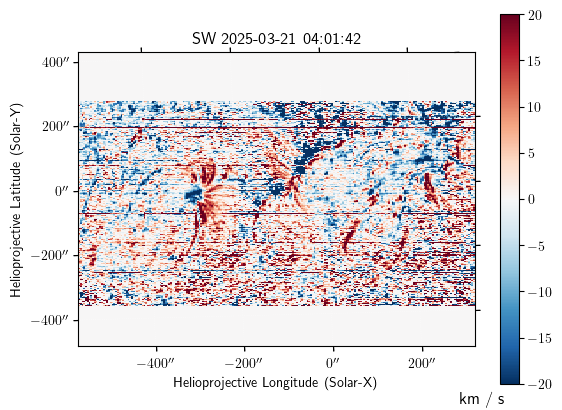

In [ ]:
doppler_map_centered = sunpy.map.Map(doppler_map.data - np.nanmedian(doppler_map.data), doppler_map.meta)
doppler_map_centered.peek(vmin=-20, vmax=20, cmap='RdBu_r', aspect = 0.2)

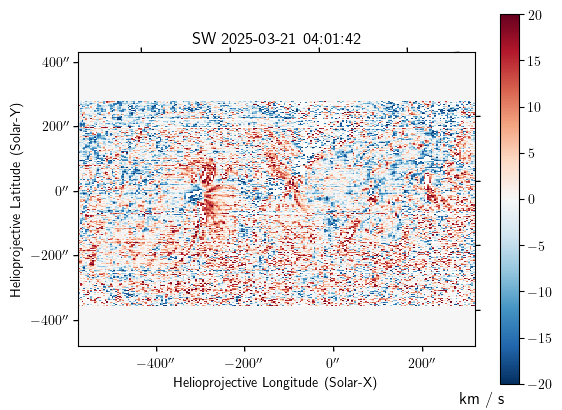

In [ ]:
# Define physical Doppler limits (e.g., ±200 km/s)
vmin, vmax = -20, 20

# Apply mask
value_masked_data = np.where((doppler_map_centered.data > vmin) & (doppler_map_centered.data < vmax),
                             doppler_map_centered.data, np.nan)

# Create new map
value_masked_map = sunpy.map.Map(value_masked_data, doppler_map_centered.meta)

value_masked_map.peek(vmin=-20, vmax=20, cmap='RdBu_r', aspect = 0.2)